## Importing Modules and Data

In [71]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
census_data = pd.read_csv("/gss_clean.csv")
survey_data = pd.read_csv("/ces2019-phone_clean.csv")

<ipython-input-71-ccfa53038746>:8: DtypeWarning: Columns (167) have mixed types. Specify dtype option on import or set low_memory=False.
  survey_data = pd.read_csv("/ces2019-phone_clean.csv")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

## Data Cleaning

In [72]:
provinces = [
    "Newfoundland and Labrador", "Prince Edward Island", "Nova Scotia", "New Brunswick",
    "British Columbia", "Quebec", "Ontario", "Manitoba", "Saskatchewan",
    "Alberta"
]

edu_levels = [
    "Less than high school diploma or its equivalent",
    "High school diploma or a high school equivalency certificate",
    "Bachelor's degree (e.g. B.A., B.Sc., LL.B.)",
    "Some university",
    "University certificate, diploma or degree above the bachelor's level",
    "Completed technical, community college, CEGEP, College"
]

marriage_statuses = ["Married", "Living common-law", "Divorced", "Separated", "Widowed", "Single, never married"]

education_mapping = {
    1: "Less than high school diploma or its equivalent",
    2: "High school diploma or a high school equivalency certificate",
    3: "Completed technical, community college, CEGEP, College",
    4: "Some university",
    5: "Bachelor's degree (e.g. B.A., B.Sc., LL.B.)",
    6: "University certificate, diploma or degree above the bachelor's level"
}

census_data = census_data[['education', 'age', 'province', 'marital_status', 'is_male']]
census_data = census_data.dropna()

census_data['education'] = census_data['education'].map({
    "Less than high school diploma or its equivalent": "Less than high school diploma or its equivalent",
    "High school diploma or a high school equivalency certificate": "High school diploma or a high school equivalency certificate",
    "Bachelor's degree (e.g. B.A., B.Sc., LL.B.)": "Bachelor's degree (e.g. B.A., B.Sc., LL.B.)",
    "College, CEGEP or other non-university certificate or di...": "Completed technical, community college, CEGEP, College",
    "Trade certificate or diploma": "Completed technical, community college, CEGEP, College",
    "University certificate or diploma below the bachelor's level": "Some university",
    "University certificate, diploma or degree above the bach...": "University certificate, diploma or degree above the bachelor's level",
})

census_data['province_index'] = pd.Categorical(census_data['province'], categories=provinces).codes
census_data['education_index'] = pd.Categorical(census_data['education'], categories=edu_levels).codes
census_data['marital_status_index'] = pd.Categorical(census_data['marital_status'], categories=marriage_statuses).codes

print(len(census_data))

survey_data['age'] = 2019 - survey_data['q2']
survey_data['province'] = survey_data['q4'].map({i + 1: prov for i, prov in enumerate(provinces)})
print(len(survey_data))

survey_data['education'] = survey_data['q61'].map(education_mapping)

survey_data['is_male'] = survey_data['q3'].map({1: 1, 2: 0})
survey_data['marital_status'] = survey_data['p50'].map({i + 1: status for i, status in enumerate(marriage_statuses)})
survey_data['vote_liberal'] = (survey_data['q11'] == 1).astype('category')

survey_data['province'] = pd.Categorical(survey_data['province'], categories=provinces)
survey_data['education'] = pd.Categorical(survey_data['education'], categories=edu_levels)
survey_data['marital_status'] = pd.Categorical(survey_data['marital_status'], categories=marriage_statuses)

survey_data = survey_data[['age', 'province', 'is_male', 'marital_status', 'education', 'vote_liberal']].dropna()

stratified_census = census_data.groupby(['age', 'province', 'is_male', 'marital_status', 'education']).size().reset_index(name='N_cell')
stratified_census['Prop_cell'] = stratified_census['N_cell'] / census_data.shape[0]

stratified_census['province'] = pd.Categorical(stratified_census['province'], categories=survey_data['province'].cat.categories)


20257
4021


### Data Cleaning:


1.   Lists of provinces, education levels, and marital statuses are created for categorical data mapping.

2.   In census_data, only select columns ('education', 'age', 'province', 'marital_status', 'is_male') are kept, and missing values (NaNs) are dropped.

3. In survey_data, the age is calculated by subtracting the survey response year (2019) from the birth year (q2). Province, education, gender (is_male), and marital status are mapped from survey codes to human-readable categories.

4. The column vote_liberal is created as a categorical variable based on the response to q11.

5. Categorical data in survey_data ('province', 'education', 'marital_status') are converted into pandas categorical data types, ensuring consistency in categories with census_data.





### Stratification of Census Data:


1.   census_data is grouped by demographic categories ('age', 'province', 'is_male', 'marital_status', 'education'), and the size of each group is calculated. This is used to create a stratified dataset where each row represents a unique combination of demographic characteristics.

2. A new column Prop_cell is added, representing the proportion of each cell (or demographic combination) relative to the total dataset.

3. The province column in stratified_census is converted to the same categorical type as in survey_data for consistency.

## Exploratory data analysis

              age     is_male
count  689.000000  689.000000
mean    52.496372    0.645864
std     18.131554    0.478598
min     18.000000    0.000000
25%     39.000000    0.000000
50%     55.000000    1.000000
75%     66.000000    1.000000
max     92.000000    1.000000
British Columbia             154
Alberta                      124
Quebec                        92
Manitoba                      62
Ontario                       56
Saskatchewan                  55
Prince Edward Island          39
Nova Scotia                   37
New Brunswick                 37
Newfoundland and Labrador     33
Name: province, dtype: int64
Bachelor's degree (e.g. B.A., B.Sc., LL.B.)                             365
University certificate, diploma or degree above the bachelor's level    164
Some university                                                         118
Completed technical, community college, CEGEP, College                   25
High school diploma or a high school equivalency certificate       

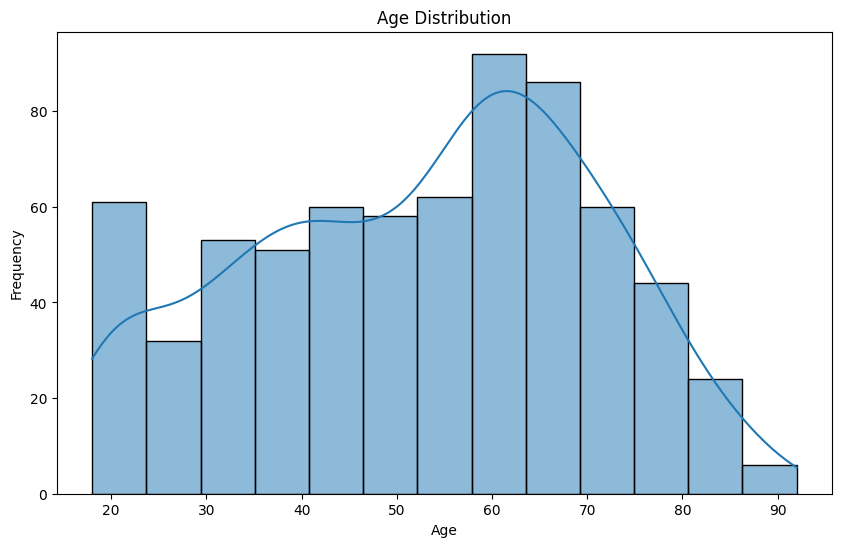

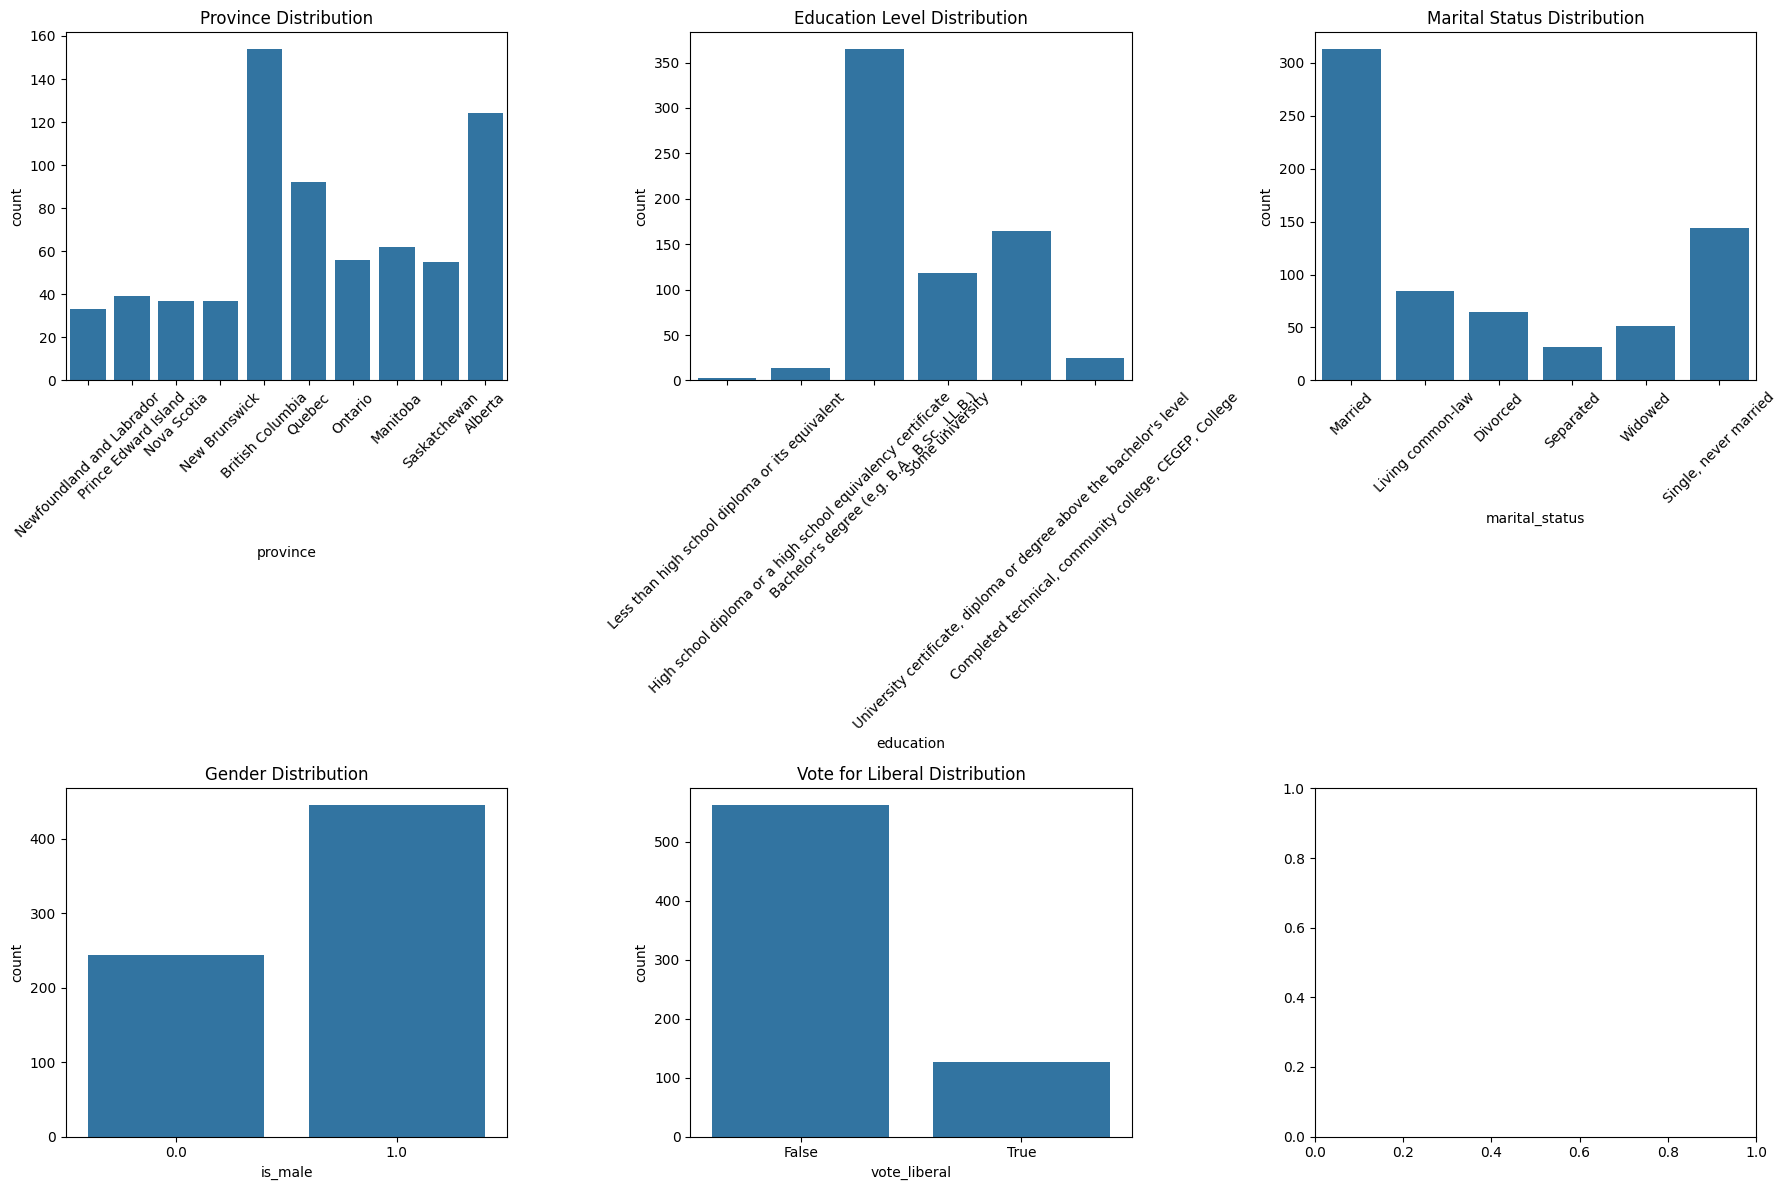

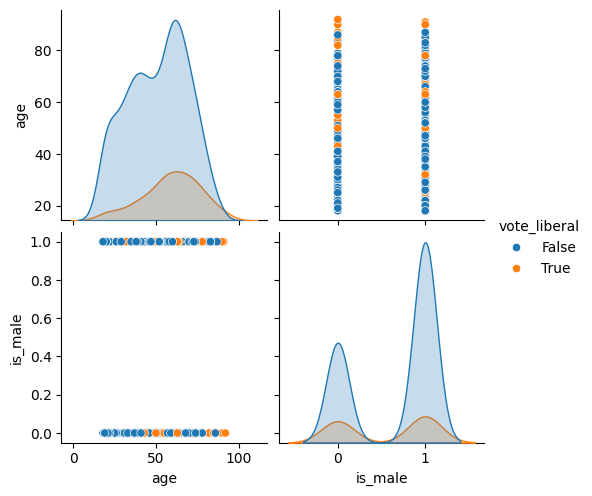

<ipython-input-18-2b35caab8c40>:42: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(survey_data.corr(), annot=True, cmap='coolwarm')


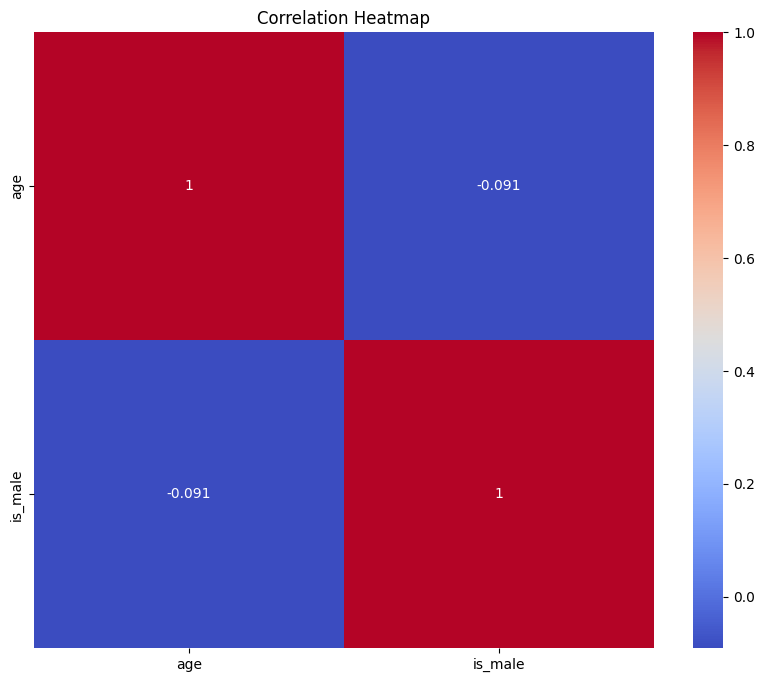

In [ ]:
print(survey_data.describe())

print(survey_data['province'].value_counts())
print(survey_data['education'].value_counts())
print(survey_data['marital_status'].value_counts())
print(survey_data['is_male'].value_counts())
print(survey_data['vote_liberal'].value_counts())

plt.figure(figsize=(10, 6))
sns.histplot(survey_data['age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
sns.countplot(ax=axes[0, 0], x='province', data=survey_data)
axes[0, 0].set_title('Province Distribution')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.countplot(ax=axes[0, 1], x='education', data=survey_data)
axes[0, 1].set_title('Education Level Distribution')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.countplot(ax=axes[0, 2], x='marital_status', data=survey_data)
axes[0, 2].set_title('Marital Status Distribution')
axes[0, 2].tick_params(axis='x', rotation=45)

sns.countplot(ax=axes[1, 0], x='is_male', data=survey_data)
axes[1, 0].set_title('Gender Distribution')

sns.countplot(ax=axes[1, 1], x='vote_liberal', data=survey_data)
axes[1, 1].set_title('Vote for Liberal Distribution')

plt.tight_layout()
plt.show()

sns.pairplot(survey_data, hue='vote_liberal', diag_kind='kde')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(survey_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


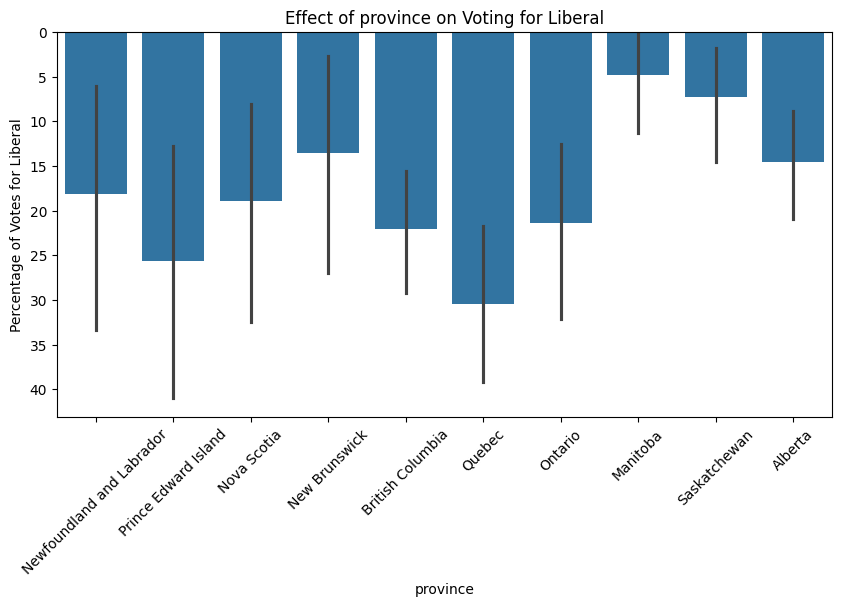

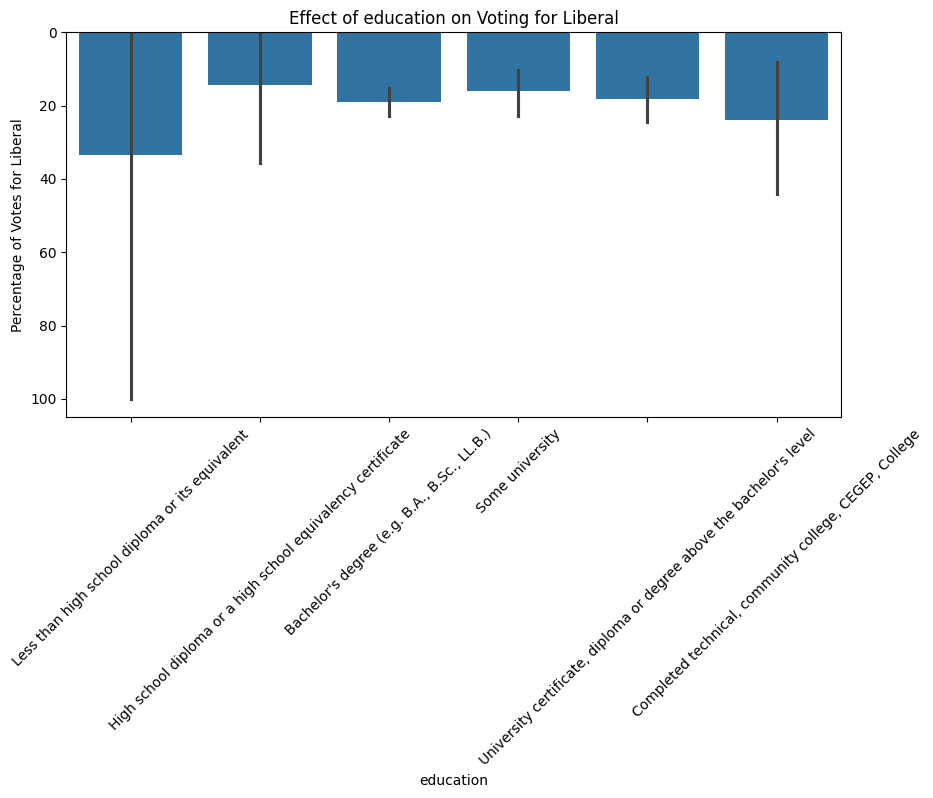

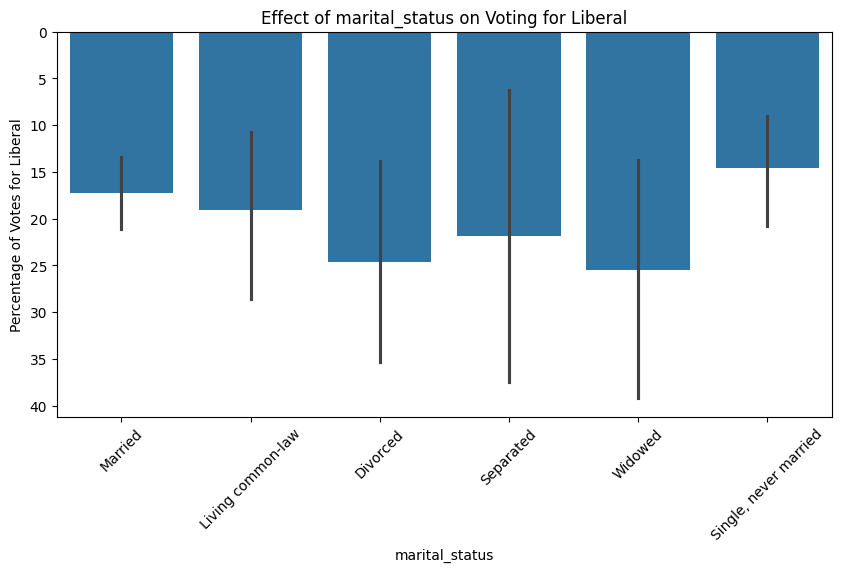

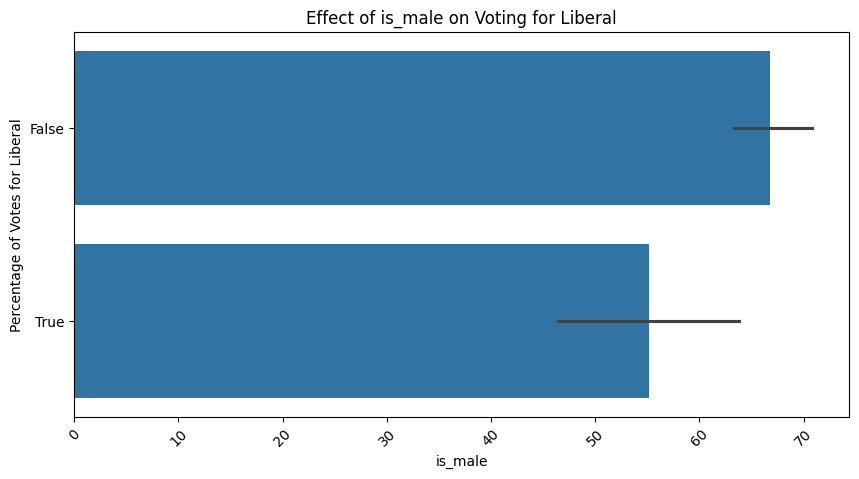

In [ ]:
categorical_vars = ['province', 'education', 'marital_status', 'is_male']

for var in categorical_vars:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=var, y='vote_liberal', data=survey_data, estimator=lambda x: sum(x) / len(x) * 100)
    plt.ylabel('Percentage of Votes for Liberal')
    plt.title(f'Effect of {var} on Voting for Liberal')
    plt.xticks(rotation=45)
    plt.show()


                age       is_male  province_index  education_index  \
count  20257.000000  20257.000000    20257.000000     20257.000000   
mean      52.186400      0.456139        5.027299         2.574814   
std       17.738148      0.498085        2.286326         1.896186   
min       15.000000      0.000000        0.000000         0.000000   
25%       37.400000      0.000000        4.000000         1.000000   
50%       54.200000      0.000000        5.000000         2.000000   
75%       66.700000      1.000000        6.000000         5.000000   
max       80.000000      1.000000        9.000000         5.000000   

       marital_status_index  
count          20257.000000  
mean               1.881128  
std                2.096598  
min                0.000000  
25%                0.000000  
50%                1.000000  
75%                4.000000  
max                5.000000  
Ontario                      5530
Quebec                       3763
British Columbia             24

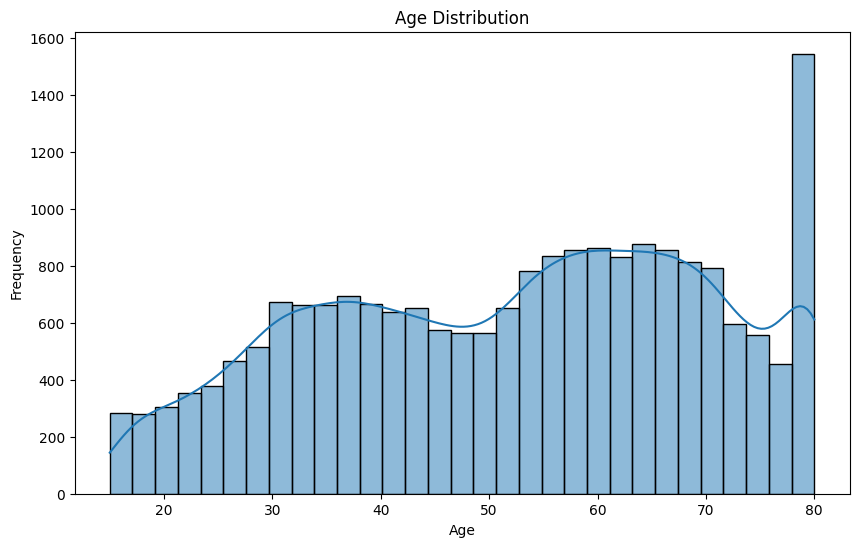

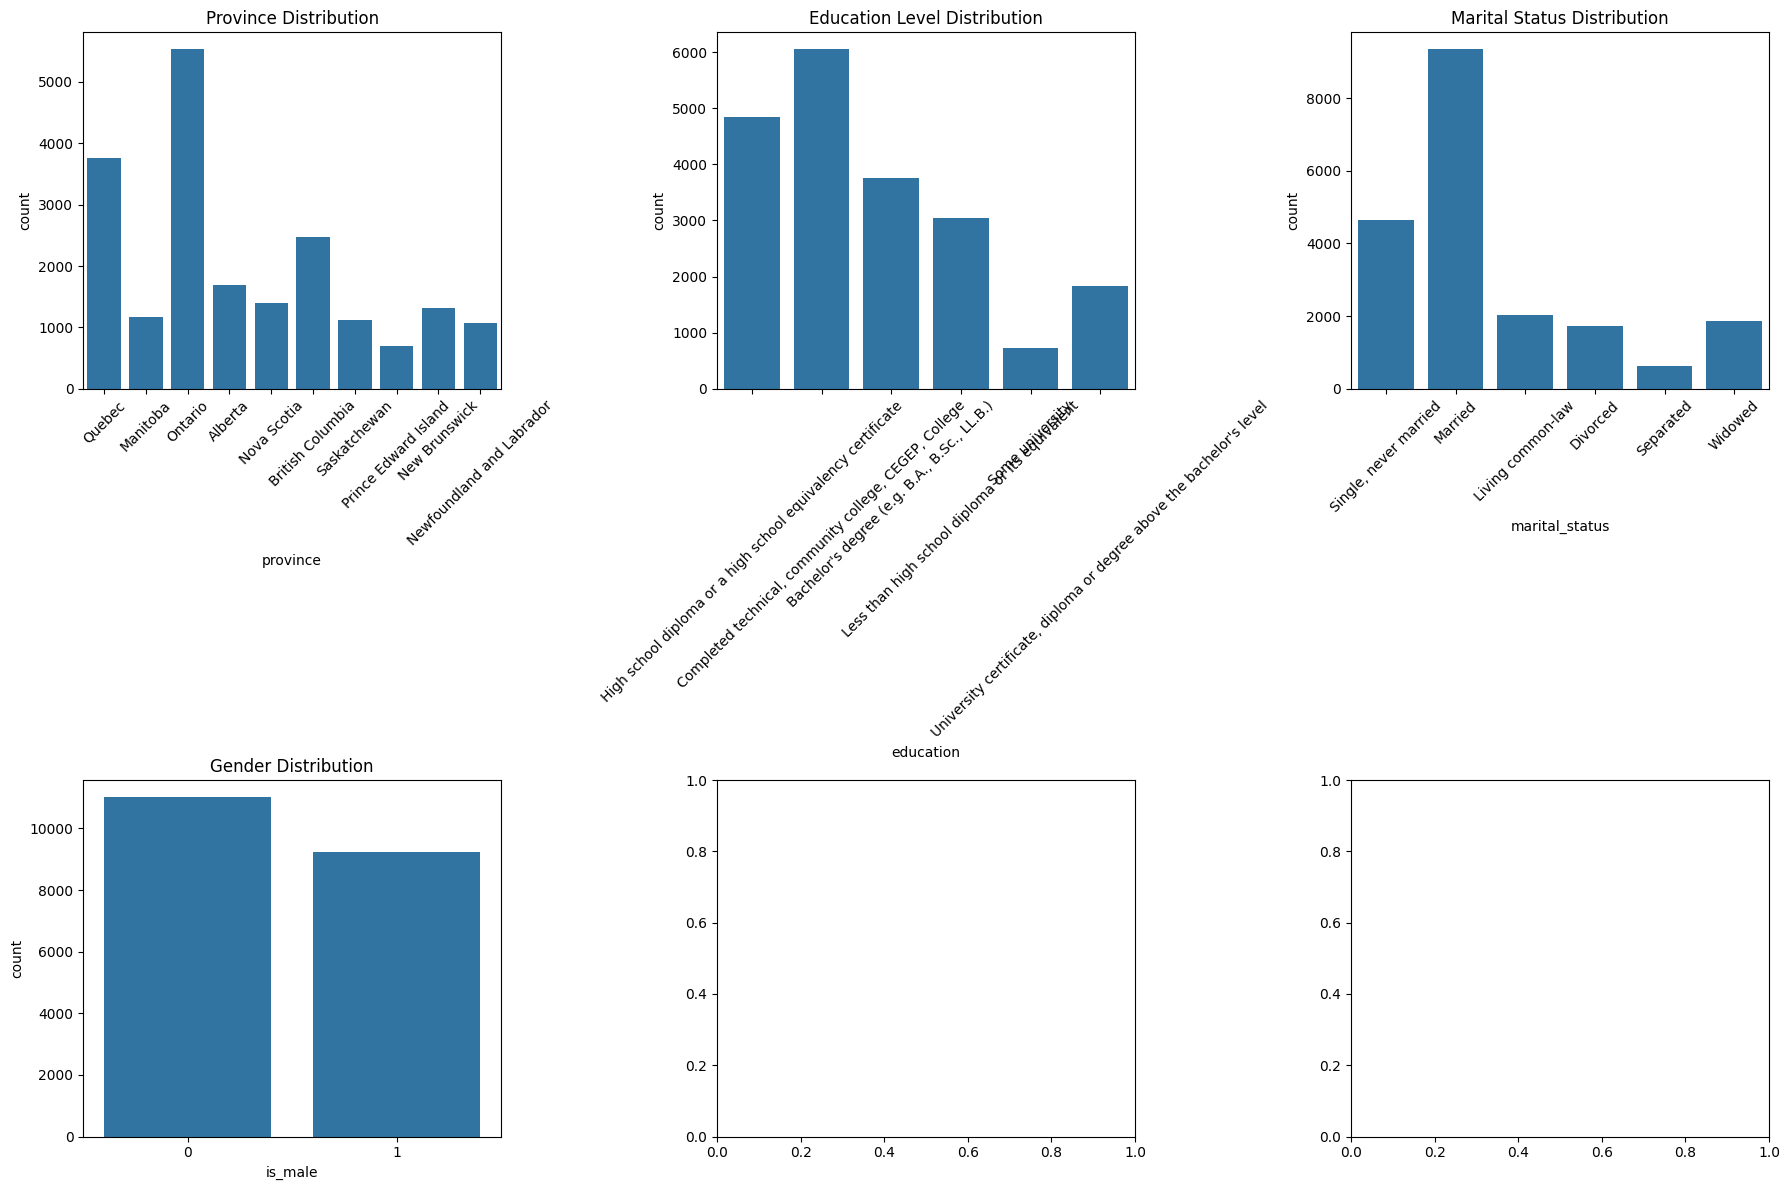

<ipython-input-20-443db3cd0cb2>:38: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(survey_data.corr(), annot=True, cmap='coolwarm')


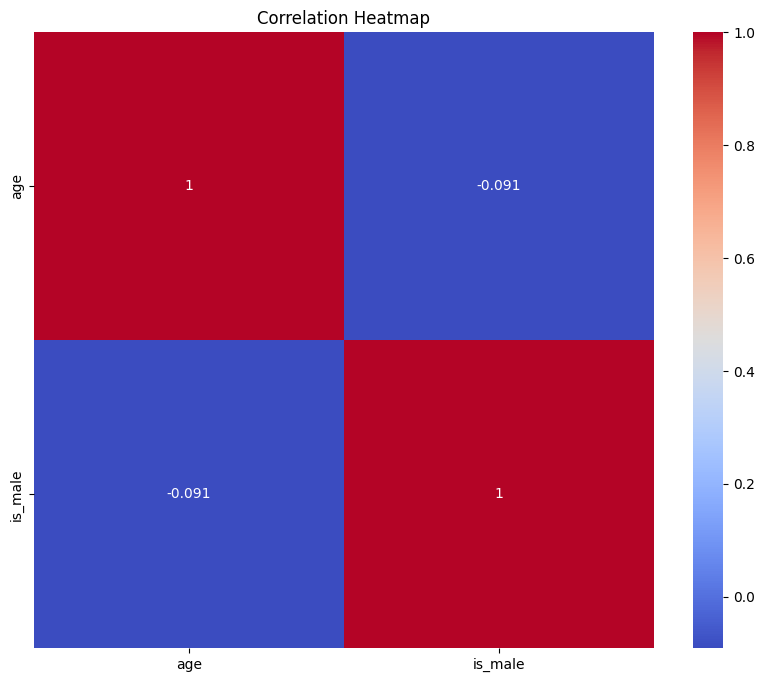

In [ ]:
print(census_data.describe())

print(census_data['province'].value_counts())
print(census_data['education'].value_counts())
print(census_data['marital_status'].value_counts())
print(census_data['is_male'].value_counts())

plt.figure(figsize=(10, 6))
sns.histplot(census_data['age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
sns.countplot(ax=axes[0, 0], x='province', data=census_data)
axes[0, 0].set_title('Province Distribution')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.countplot(ax=axes[0, 1], x='education', data=census_data)
axes[0, 1].set_title('Education Level Distribution')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.countplot(ax=axes[0, 2], x='marital_status', data=census_data)
axes[0, 2].set_title('Marital Status Distribution')
axes[0, 2].tick_params(axis='x', rotation=45)

sns.countplot(ax=axes[1, 0], x='is_male', data=census_data)
axes[1, 0].set_title('Gender Distribution')



plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 8))
sns.heatmap(survey_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Predicting the 2020 General Election Results using a Bayesian Hierarchical Model and Post-stratification

## Model

In [ ]:
survey_data['province_index'] = pd.Categorical(survey_data['province'], categories=provinces).codes
survey_data['education_index'] = pd.Categorical(survey_data['education'], categories=edu_levels).codes
survey_data['marital_status_index'] = pd.Categorical(survey_data['marital_status'], categories=marriage_statuses).codes

age_sd = survey_data['age'].std()
age_mu = survey_data['age'].mean()


with pm.Model() as model_lib:

    # Priors for the intercept and coefficients
    intercept = pm.Normal('Intercept', mu=0, sigma=1)
    is_male_coef = pm.Normal('is_male_coef', mu=0, sigma=1)

    # Priors for the group-level means
    education_mu = pm.Normal('education_mu', mu=0, sigma=1)
    education_sd = pm.HalfNormal('education_sd', sigma=1)

    province_mu = pm.Normal('province_mu', mu=0, sigma=1)
    province_sd = pm.HalfNormal('province_sd', sigma=1)

    marital_status_mu = pm.Normal('marital_status_mu', mu=0, sigma=1)
    marital_status_sd = pm.HalfNormal('marital_status_sd', sigma=1)

    # Non-centered parameterization for the group-level effects
    education_offset_raw = pm.Normal('education_offset_raw', mu=0, sigma=1, shape=survey_data['education_index'].nunique())
    education_offset = pm.Deterministic('education_offset', education_mu + education_offset_raw * education_sd)

    province_offset = pm.Normal('province_offset', mu=0, sigma=1, shape=survey_data['province_index'].nunique())

    marital_status_offset = pm.Normal('marital_status_offset', mu=0, sigma=1, shape=survey_data['marital_status_index'].nunique())

    # Mutable data for posterior predictions
    d_is_male = pm.MutableData('is_male', survey_data['is_male'])
    d_age = pm.MutableData('age', survey_data['age'])
    d_education_index = pm.MutableData('education_index', survey_data['education_index'])
    d_province_index = pm.MutableData('province_index', survey_data['province_index'])
    d_marital_status_index = pm.MutableData('marital_status_index', survey_data['marital_status_index'])
    d_vote_liberal = pm.MutableData('t_vote_liberal', survey_data['vote_liberal'])

    # Total effect for each predictor
    theta = (intercept +
             is_male_coef * d_is_male +
             pm.Normal('age_effect', mu=0, sigma=age_sd) * (d_age - age_mu) +
             education_offset[d_education_index] +
             province_offset[d_province_index] +
             marital_status_offset[d_marital_status_index])

    # Likelihood
    likelihood = pm.Bernoulli('vote_liberal', logit_p=theta, observed=d_vote_liberal, shape=d_vote_liberal.shape)

    # Sampling from the posterior distribution
    trace_lib = pm.sample(2000, tune=2000, cores=4, random_seed=1234, target_accept=0.95)


### Bayesian Model Setup (model_lib):

Priors for Intercept and Coefficients:


*   intercept: A normal prior is set for the intercept of the model.
* is_male_coef: A normal prior for the coefficient of the binary variable is_male, representing gender.

Priors for Group-Level Effects:

* education_mu, province_mu, marital_status_mu: Normal priors for the group-level means of education, province, and marital_status.
* education_sd, province_sd, marital_status_sd: HalfNormal priors for the standard deviations of these group-level effects. HalfNormal is used as it restricts the values to be positive, which is suitable for standard deviations.

Non-Centered Parameterization:

* This is used for the group-level effects to improve sampling efficiency.
* education_offset_raw, province_offset, marital_status_offset: These are the non-centered parameters. They are drawn from a standard normal distribution and then transformed to represent the actual group-level effects.

Total Effect (theta):

* The total effect combines the intercept, individual coefficients, and the group-level effects. It’s calculated as a linear combination of all these factors, with is_male and age included as covariates. The age effect is normalized by subtracting the mean and scaling by the standard deviation.

Likelihood:

* The likelihood of the model is defined as a Bernoulli distribution, which is appropriate for binary outcomes like voting behavior. The probability (logit_p) is calculated from the linear predictor theta.

Sampling:

* The model uses MCMC sampling to estimate the posterior distribution of the parameters. pm.sample is used to draw 2000 samples, tuning for another 2000 iterations. Multiple cores are used for parallel sampling, and a high target_accept value is set for better convergence.

# Model Diagnostics/Fit


Make Model predictions from sample:

In [ ]:
#2000 samples
with model_lib:
    ppc = pm.sample_posterior_predictive(trace_lib)
    log_likelihood_lib = pm.compute_log_likelihood(trace_lib)

In [ ]:
np.array(ppc.posterior_predictive.vote_liberal).mean()

0.18551578374455732

(array([  24.,  171.,  754., 1430., 2279., 1927.,  954.,  376.,   76.,
           9.]),
 array([0.11901306, 0.13309144, 0.14716981, 0.16124819, 0.17532656,
        0.18940493, 0.20348331, 0.21756168, 0.23164006, 0.24571843,
        0.25979681]),
 <BarContainer object of 10 artists>)

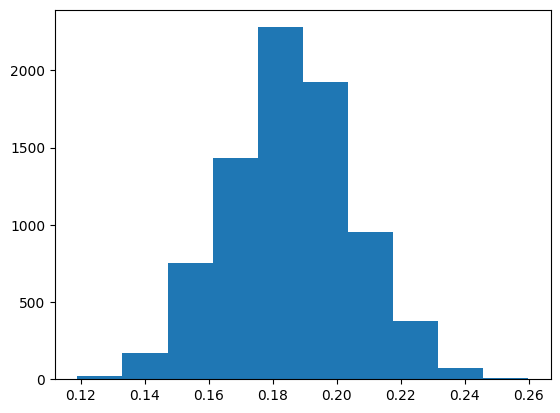

In [ ]:
plt.hist(np.array(ppc.posterior_predictive.vote_liberal).mean(-1).flatten())

In [ ]:
#binary_liberal_data = np.array(survey_data['vote_liberal'], dtype=int)
predicted_data = ppc['posterior_predictive'].to_array().values
observed_data = ppc['observed_data'].to_array().values

mse = np.mean((observed_data - np.mean(predicted_data[0]))**2)

prediction = 0
#4 markov chains
for i in range(4):
  wrong = 0
  for j in range(len(observed_data[0])):
    if predicted_data[0][0][i][j] != observed_data[0][i]:
      wrong += 1
  prediction += (689 - wrong) / 689

log_likelihood_values = log_likelihood_lib['log_likelihood'].to_array().values


# Compute the average log likelihood
average_log_likelihood = np.mean(log_likelihood_values)
print("Average Log Likelihood:", average_log_likelihood)

print("Prediction accuracy: ", prediction / 4)
print("Mean Squared Error (MSE):", mse)

Average Log Likelihood: -0.4495313662203183
Prediction accuracy:  0.8044267053701015
Mean Squared Error (MSE): 0.15035078080628542


Our model seems to have a good prediction accuracy of around 80%. We only trained it on a survey size of 689 and a sampling size of 8000.

**Compare to Baseline & Simpler Models:**

Baseline Model (Hierarchial Centered)

In [ ]:
#Get Baseline model (This is the full model) model compare
with pm.Model() as model_lib_baseline:

    # Priors for the intercept and coefficients
    intercept = pm.Normal('Intercept', mu=0, sigma=1)
    is_male_coef = pm.Normal('is_male', mu=0, sigma=1)

    # Priors for the group-level means
    education_mu = pm.Normal('education_mu', mu=0, sigma=1)
    education_sd = pm.HalfNormal('education_sd', sigma=1)

    province_mu = pm.Normal('province_mu', mu=0, sigma=1)
    province_sd = pm.HalfNormal('province_sd', sigma=1)

    marital_status_mu = pm.Normal('marital_status_mu', mu=0, sigma=1)
    marital_status_sd = pm.HalfNormal('marital_status_sd', sigma=1)

    education = pm.Normal('education_offset', mu=education_mu, sigma=education_sd, shape=survey_data['education_index'].nunique())

    province = pm.Normal('province', mu=province_mu, sigma=province_sd, shape=survey_data['province_index'].nunique())

    marital_status = pm.Normal('marital_status', mu=marital_status_mu, sigma= marital_status_sd, shape=survey_data['marital_status_index'].nunique())

    # Total effect for each predictor
    theta = (intercept +
             is_male_coef * survey_data['is_male'] +
             pm.Normal('age_effect', mu=0, sigma=age_sd) * (survey_data['age'] - age_mu) +
             education[survey_data['education_index']] +
             province[survey_data['province_index']] +
             marital_status[survey_data['marital_status_index']])

    # Likelihood
    likelihood_baseline = pm.Bernoulli('vote_liberal', logit_p=theta, observed=survey_data['vote_liberal'])

    # Sampling from the posterior distribution
    trace_lib_baseline = pm.sample(2000, tune=2000, cores=4, random_seed=1234, target_accept=0.95)

ERROR:pymc.stats.convergence:There were 249 divergences after tuning. Increase `target_accept` or reparameterize.


Because we are taking much smaller steps, due to lower variance and a low amount of data in some areas of the dataset, sampling time is drastically increased. We also see 249 divergences from the sampling chains! Now we will compare prediction accuracy:

In [ ]:
#code for model comparison
with model_lib:
    pm.sample(idata_kwargs={"log_likelihood": True})
with model_lib_baseline:
    log_likelihood_lib_base = pm.compute_log_likelihood(trace_lib_baseline)

In [ ]:
with model_lib_baseline:
    ppc = pm.sample_posterior_predictive(trace_lib_baseline)

In [ ]:
predicted_data = ppc['posterior_predictive'].to_array().values
observed_data = ppc['observed_data'].to_array().values

mse = np.mean((observed_data - np.mean(predicted_data[0]))**2)

prediction = 0
#4 markov chains
for i in range(4):
  wrong = 0
  for j in range(len(observed_data[0])):
    if predicted_data[0][0][i][j] != observed_data[0][i]:
      wrong += 1
  prediction += (689 - wrong) / 689

print("Prediction accuracy: ", prediction / 4)
print("Mean Squared Error (MSE):", mse)
log_likelihood_base = log_likelihood_lib_base['log_likelihood'].to_array().values
average_log_likelihood_base = np.mean(log_likelihood_base)
print("Baseline Model Average Log Likelihood:", average_log_likelihood_base)

Prediction accuracy:  0.9459361393323659
Mean Squared Error (MSE): 0.14205277639597502
Baseline Model Average Log Likelihood: -0.4177995613486764


Here our hierarichal centered model seems to be performing a bit better with an 84% prediction accuracy. And a similar log-likelihood. Let's look further:

0.1679702380952381


(array([  40.,  309., 1669., 2251., 2308.,  952.,  379.,   76.,   12.,
           4.]),
 array([0.06666667, 0.09285714, 0.11904762, 0.1452381 , 0.17142857,
        0.19761905, 0.22380952, 0.25      , 0.27619048, 0.30238095,
        0.32857143]),
 <BarContainer object of 10 artists>)

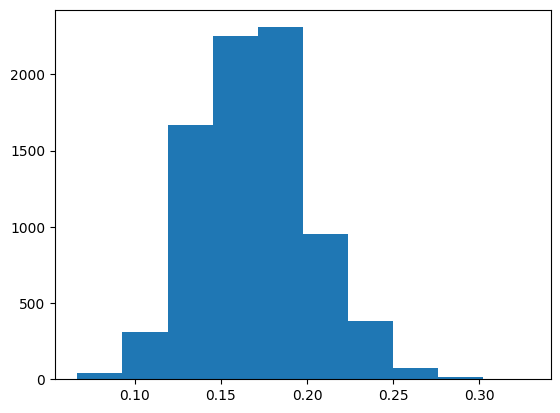

In [ ]:
print(np.array(ppc.posterior_predictive.vote_liberal).mean())
plt.hist(np.array(ppc.posterior_predictive.vote_liberal).mean(-1).flatten())

**Model Comparison with WAIC and LOO-CV**

In [ ]:
az.compare({"hierarchical_centered": trace_lib_baseline, "uncentered(Final model)": trace_lib}, ic='loo')

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank   elpd_loo      p_loo  elpd_diff   weight  \
hierarchical_centered       0 -92.919953   9.671002   0.000000  0.78267   
uncentered(Final model)     1 -94.023067  14.244425   1.103114  0.21733   

                               se       dse  warning scale  
hierarchical_centered    9.379650  0.000000     True   log  
uncentered(Final model)  9.908468  1.987353    False   log

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


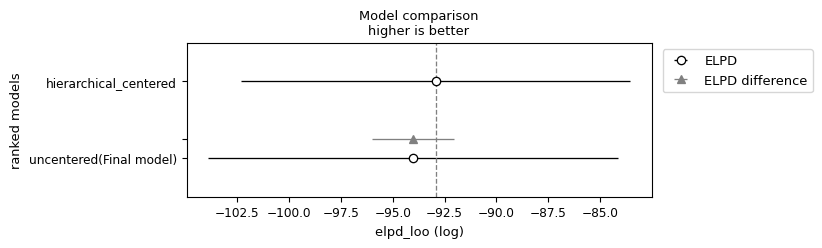

In [ ]:
az.plot_compare(az.compare({"hierarchical_centered": trace_lib_baseline, "uncentered(Final model)": trace_lib}), insample_dev=False);

As we can see, our hierarchical cenetered model makes better predictions than our uncenetered model (the one we use); however, this comes with a trade off of increased model complexity and diverging samples. Our sampling time nearly 16 times slower, and we took a much higher hit in performance for little gain in predictive accuracy. So although, this model is better able to capture the underlying data, we ultimately concluded that it was not worth the decrease in efficiency.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


<Axes: >

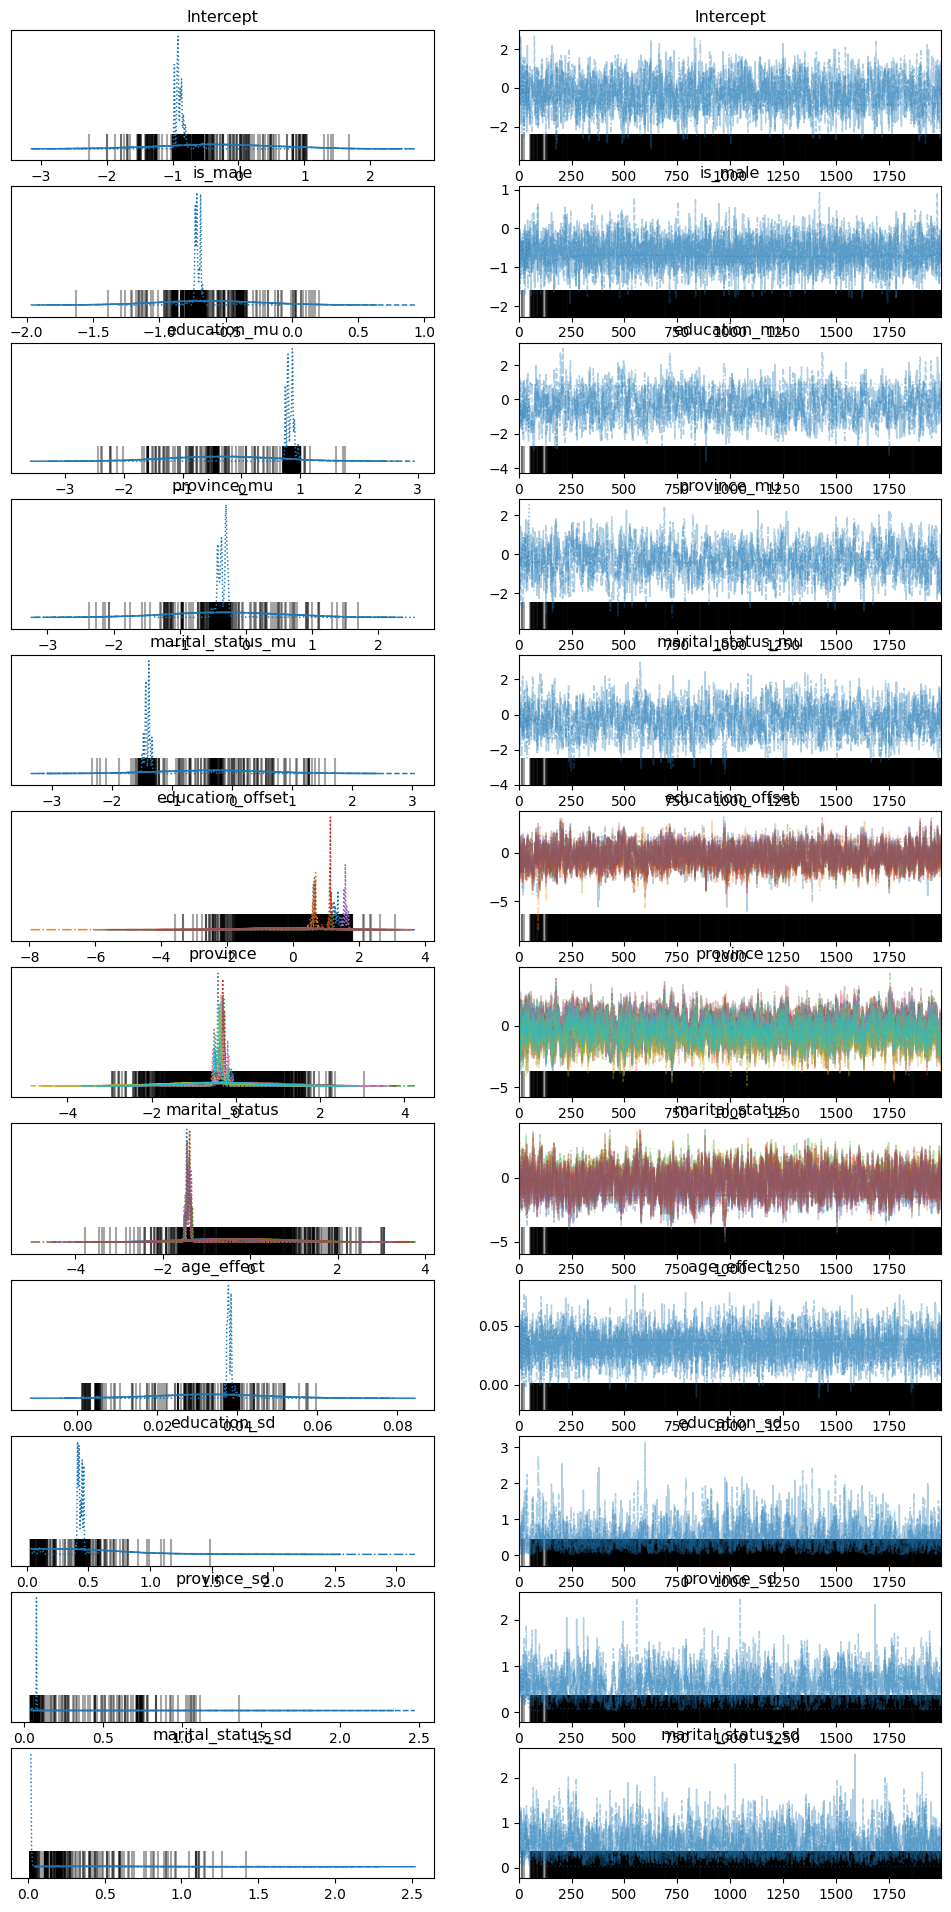

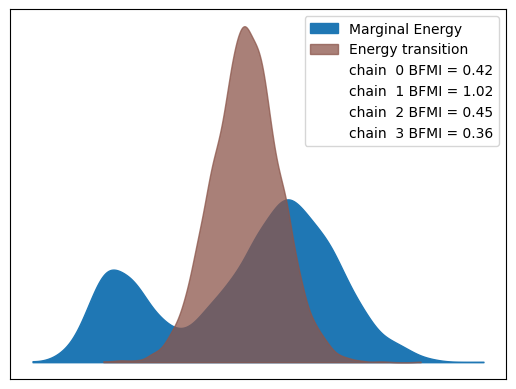

In [ ]:
az.plot_trace(trace_lib_baseline)
az.plot_energy(trace_lib_baseline)

As we can see from the energy graph, the energy transition peaks higher than the marginal energy, and appears to be quite unstable. This signals poor mixing and inefficient sampling, which was hinted at earlier from the 249 divergences in our sampling chains.

**Compare without non-cenetered parameterization for "education_offset"**

In [ ]:
with pm.Model() as model_lib_nonparameterize:

    # Priors for the intercept and coefficients
    intercept = pm.Normal('Intercept', mu=0, sigma=1)
    is_male_coef = pm.Normal('is_male', mu=0, sigma=1)

    # Priors for the group-level means
    education_mu = pm.Normal('education_mu', mu=0, sigma=1)
    education_sd = pm.HalfNormal('education_sd', sigma=1)

    province_mu = pm.Normal('province_mu', mu=0, sigma=1)
    province_sd = pm.HalfNormal('province_sd', sigma=1)

    marital_status_mu = pm.Normal('marital_status_mu', mu=0, sigma=1)
    marital_status_sd = pm.HalfNormal('marital_status_sd', sigma=1)

    # Non-centered parameterization for the group-level effects
    education_offset= pm.Normal('education_offset', mu=0, sigma=1, shape=survey_data['education_index'].nunique())

    province_offset = pm.Normal('province_offset', mu=0, sigma=1, shape=survey_data['province_index'].nunique())

    marital_status_offset = pm.Normal('marital_status_offset', mu=0, sigma=1, shape=survey_data['marital_status_index'].nunique())

    # Total effect for each predictor
    theta = (intercept +
             is_male_coef * survey_data['is_male'] +
             pm.Normal('age_effect', mu=0, sigma=age_sd) * (survey_data['age'] - age_mu) +
             education_offset[survey_data['education_index']] +
             province_offset[survey_data['province_index']] +
             marital_status_offset[survey_data['marital_status_index']])

    # Likelihood
    likelihood_nonparameterize = pm.Bernoulli('vote_liberal', logit_p=theta, observed=survey_data['vote_liberal'])

    # Sampling from the posterior distribution
    trace_lib_nonparameterize = pm.sample(2000, tune=2000, cores=4, random_seed=1234, target_accept=0.95)


In [ ]:
#code for model comparison
with model_lib:
    pm.sample(idata_kwargs={"log_likelihood": True})
with model_lib_nonparameterize:
    log_likelihood_lib_nonparameterize = pm.compute_log_likelihood(trace_lib_nonparameterize)
    ppc = pm.sample_posterior_predictive(trace_lib_nonparameterize)

In [ ]:
predicted_data = ppc['posterior_predictive'].to_array().values
observed_data = ppc['observed_data'].to_array().values

mse = np.mean((observed_data - np.mean(predicted_data[0]))**2)

prediction = 0
#4 markov chains
for i in range(4):
  wrong = 0
  for j in range(len(observed_data[0])):
    if predicted_data[0][0][i][j] != observed_data[0][i]:
      wrong += 1
  prediction += (689 - wrong) / 689

print("Prediction accuracy: ", prediction / 4)
print("Mean Squared Error (MSE):", mse)
log_likelihood_nonparameterize = log_likelihood_lib_nonparameterize['log_likelihood'].to_array().values
average_log_likelihood_nonparameterize = np.mean(log_likelihood_nonparameterize)
print("Non-parameterized Model Average Log Likelihood:", average_log_likelihood_nonparameterize)

Prediction accuracy:  0.9357764876632801
Mean Squared Error (MSE): 0.14205748021683676
Non-parameterized Model Average Log Likelihood: -0.40903890863874376


0.1755107142857143


(array([  23.,  215.,  905., 1861., 2280., 1631.,  784.,  232.,   56.,
          13.]),
 array([0.07142857, 0.0947619 , 0.11809524, 0.14142857, 0.1647619 ,
        0.18809524, 0.21142857, 0.2347619 , 0.25809524, 0.28142857,
        0.3047619 ]),
 <BarContainer object of 10 artists>)

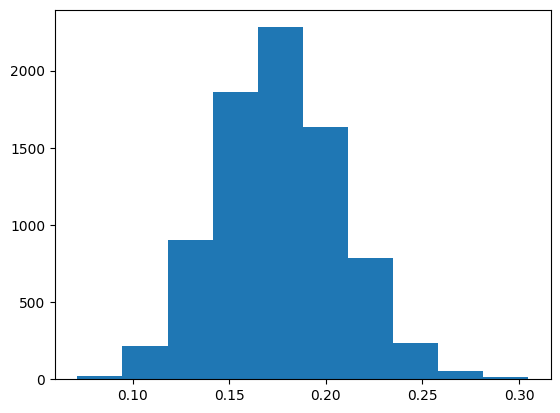

In [ ]:
print(np.array(ppc.posterior_predictive.vote_liberal).mean())
plt.hist(np.array(ppc.posterior_predictive.vote_liberal).mean(-1).flatten())

In [ ]:
az.compare({"unparamaterized education": trace_lib_nonparameterize, "parameterized(Final model)": trace_lib}, ic='loo')

rank   elpd_loo      p_loo  elpd_diff    weight  \
parameterized(Final model)     0 -94.023067  14.244425   0.000000  0.868685   
unparamaterized education      1 -94.245855  14.951571   0.222788  0.131315   

                                  se       dse  warning scale  
parameterized(Final model)  9.908468  0.000000    False   log  
unparamaterized education   9.977713  0.778151    False   log

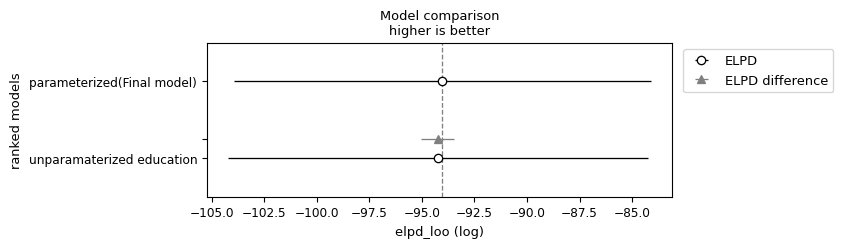

In [ ]:
az.plot_compare(az.compare({"unparamaterized education": trace_lib_nonparameterize, "parameterized(Final model)": trace_lib}), insample_dev=False);

As you can see our parameterized model is better able to capture the underlying data struture than the model that does not parameterize the education_offset value. Although it has a higher prediction accuracy, the decrease in complexity of the model could have lead to overfitting or biased training.

# Predicting Election Results using Post-stratification

In [ ]:
with model_lib:
    post_pred_lib = pm.sample_posterior_predictive(trace_lib)

In [ ]:
print("Average number of predicted liberal voters %", np.array(post_pred_lib.posterior_predictive.vote_liberal).mean() * 100)

Average number of predicted liberal voters % 17.43988095238095


In [93]:
print("Liberal voters % in survey", survey_data['vote_liberal'].astype(int).mean() * 100)

Liberal voters % in survey 18.432510885341074


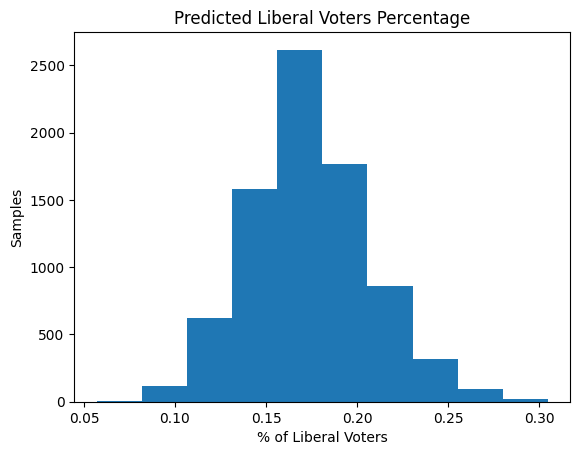

In [ ]:
plt.hist(np.array(post_pred_lib.posterior_predictive.vote_liberal).mean(-1).flatten())
plt.ylabel("Samples")
plt.xlabel("% of Liberal Voters")
plt.title("Predicted Liberal Voters Percentage");

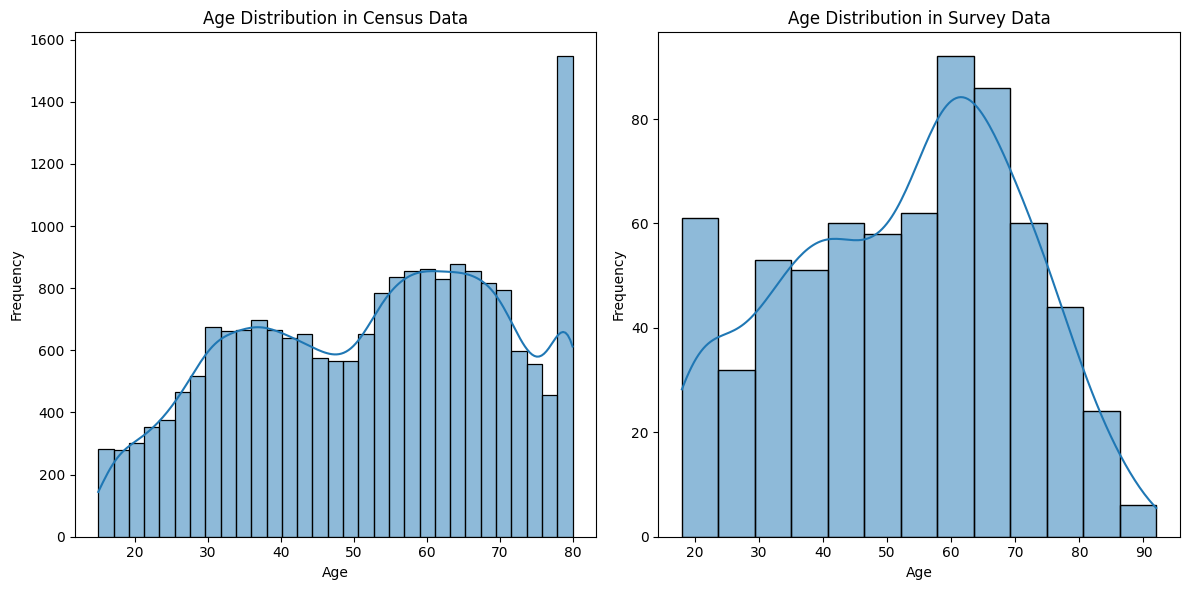

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(ax=axes[0], x=census_data['age'], kde=True)
axes[0].set_title('Age Distribution in Census Data')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

sns.histplot(ax=axes[1], x=survey_data['age'], kde=True)
axes[1].set_title('Age Distribution in Survey Data')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

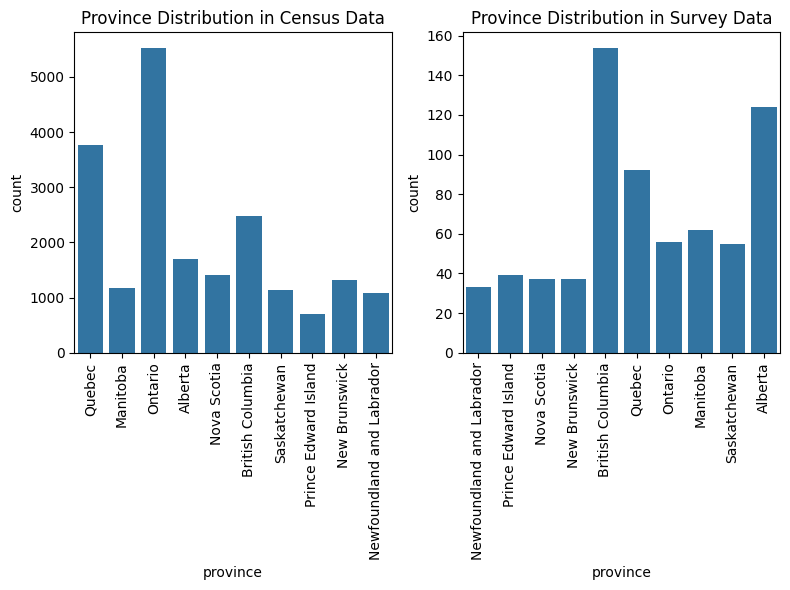

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6))
sns.countplot(ax=axes[0], x='province', data=census_data)
axes[0].set_title('Province Distribution in Census Data')
axes[0].tick_params(axis='x', rotation=90)

sns.countplot(ax=axes[1], x='province', data=survey_data)
axes[1].set_title('Province Distribution in Survey Data')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

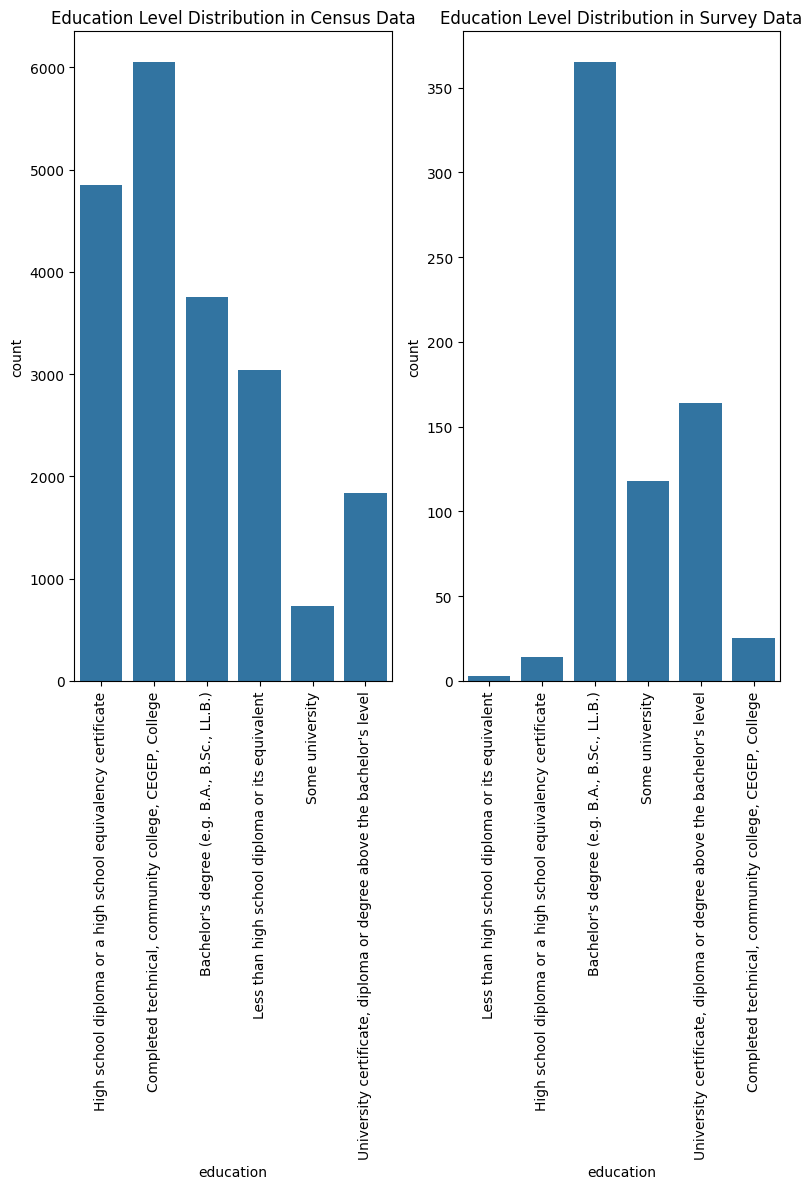

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(8, 12))

sns.countplot(ax=axes[0], x='education', data=census_data)
axes[0].set_title('Education Level Distribution in Census Data')
axes[0].tick_params(axis='x', rotation=90)

sns.countplot(ax=axes[1], x='education', data=survey_data)
axes[1].set_title('Education Level Distribution in Survey Data')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

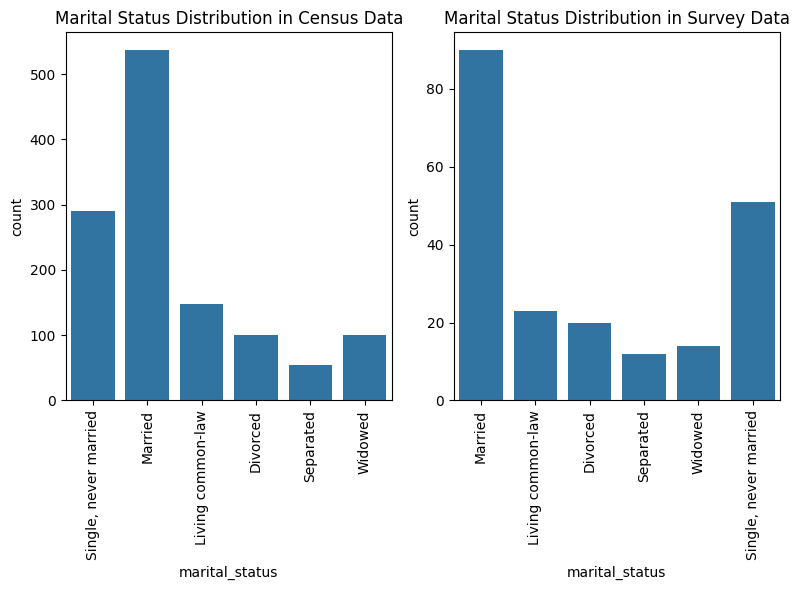

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

sns.countplot(ax=axes[0], x='marital_status', data=census_data)
axes[0].set_title('Marital Status Distribution in Census Data')
axes[0].tick_params(axis='x', rotation=90)

sns.countplot(ax=axes[1], x='marital_status', data=survey_data)
axes[1].set_title('Marital Status Distribution in Survey Data')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


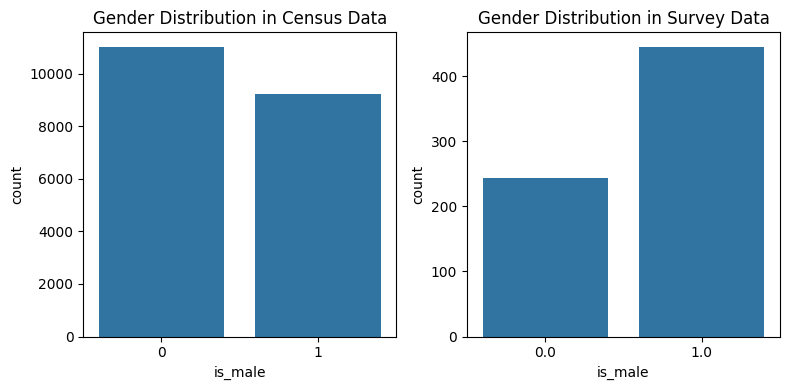

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.countplot(ax=axes[0], x='is_male', data=census_data)
axes[0].set_title('Gender Distribution in Census Data')

sns.countplot(ax=axes[1], x='is_male', data=survey_data)
axes[1].set_title('Gender Distribution in Survey Data')

plt.tight_layout()
plt.show()

The overall goal of the project was to develop a model to predict the election outcome using the survey data. Since there are significant differences between the people asked in the survey and the general population as counted in the census, we use post-stratification to correct for this difference.

Text(0.5, 1.0, 'Predicted Liberal Voters Percentage')

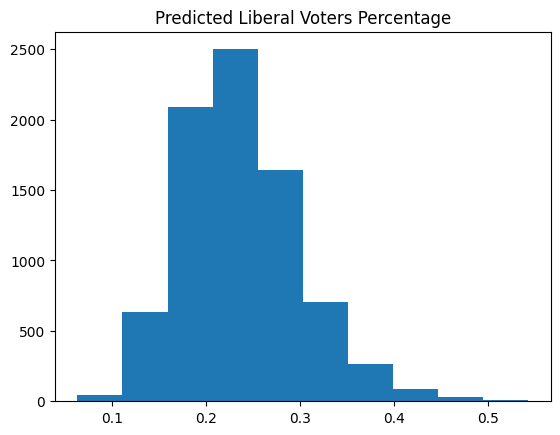

In [ ]:
with model_lib:
    pm.set_data({
        "is_male": census_data.is_male,
        "t_vote_liberal": np.ones(census_data.is_male.shape),
        "age": census_data.age.astype(int),
        "marital_status_index": census_data.marital_status_index,
        "education_index": census_data.education_index,
        "province_index": census_data.province_index,
    })
    y_test = pm.sample_posterior_predictive(trace_lib)
plt.hist(np.array(y_test.posterior_predictive.vote_liberal).round().mean(-1).flatten())
plt.title("Predicted Liberal Voters Percentage");

In [ ]:
print("Average number of predicted liberal voters %", np.array(y_test.posterior_predictive.vote_liberal).mean() * 100)

Average number of predicted liberal voters % 23.63762195121951


In our model we consider education level, age, marital status, if the person is a male and province to determine their voting behavior. Due to the large number of different configurations of age, province, education, marriage level and sex which are possible, using the data directly gives us a very imprecise estimate of the actual population. Thus for better post-stratification, we first use the census data to develop a bayesian model to describe the population. We can then use this model to sample representative samples of people. We then use our previously trained predictive model to predict the voting behaviour of this sample. Since this samples voting behaviour should be indicative of the population, we can use this to determine the expected number of votes the liberals should get.

In [73]:
num_provinces = int(census_data['province_index'].max()) + 1
num_edu = 6
num_mar = len(marriage_statuses)
data = census_data
with pm.Model() as census_sample:
  province_prior = pm.Dirichlet("province_prior", a=[1.5] * num_provinces)
  province = pm.Categorical("province", p=province_prior, observed=data['province_index'])
  is_male_prob = pm.Beta("is_male_prob", alpha=3, beta=3, shape=num_provinces)
  is_male = pm.Bernoulli("is_male", p=is_male_prob[province], observed=data['is_male'])
  marital_status_prob = pm.Dirichlet("marital_status_prob", a=np.ones((num_mar, )) * 1.5, shape=(num_provinces, 2, num_mar))
  marital_status = pm.Categorical("marital_status", p=marital_status_prob[province, is_male], observed=data['marital_status_index'])
  education_prob = pm.Dirichlet("education_prob", a=[1.5] * num_edu, shape=(num_provinces, 2, num_mar, num_edu))
  education = pm.Categorical("education", p=education_prob[province, is_male, marital_status], observed=data['education_index'])
  base_age_mu = pm.Normal("base_age_mu", mu=data['age'].mean(), sigma=data['age'].std())
  base_age_std = pm.TruncatedNormal("base_age_std", mu=data['age'].std(), sigma=5, lower=0)
  male_age_diff = pm.Normal("male_age_diff", mu=0, sigma=5)
  martial_age_diff = pm.Normal("martial_age_diff", mu=0, sigma=20, shape=num_mar)
  martial_age_std_diff = pm.Normal("martial_age_std_diff", mu=0, sigma=3, shape=num_mar)
  education_age_diff = pm.Normal("education_age_diff", mu=0, sigma=3, shape=num_edu)
  education_age_std_diff = pm.Normal("education_age_std_diff", mu=0, sigma=5, shape=num_edu)
  age = pm.Normal("age", mu=pm.Deterministic("age_factors", base_age_mu + male_age_diff * is_male + martial_age_diff[marital_status] + education_age_diff[education]),
                  sigma=pm.Deterministic("age_std", base_age_std + martial_age_std_diff[marital_status] + education_age_std_diff[education]), observed=data['age'])

  sampled_census = pm.sample(cores=2)

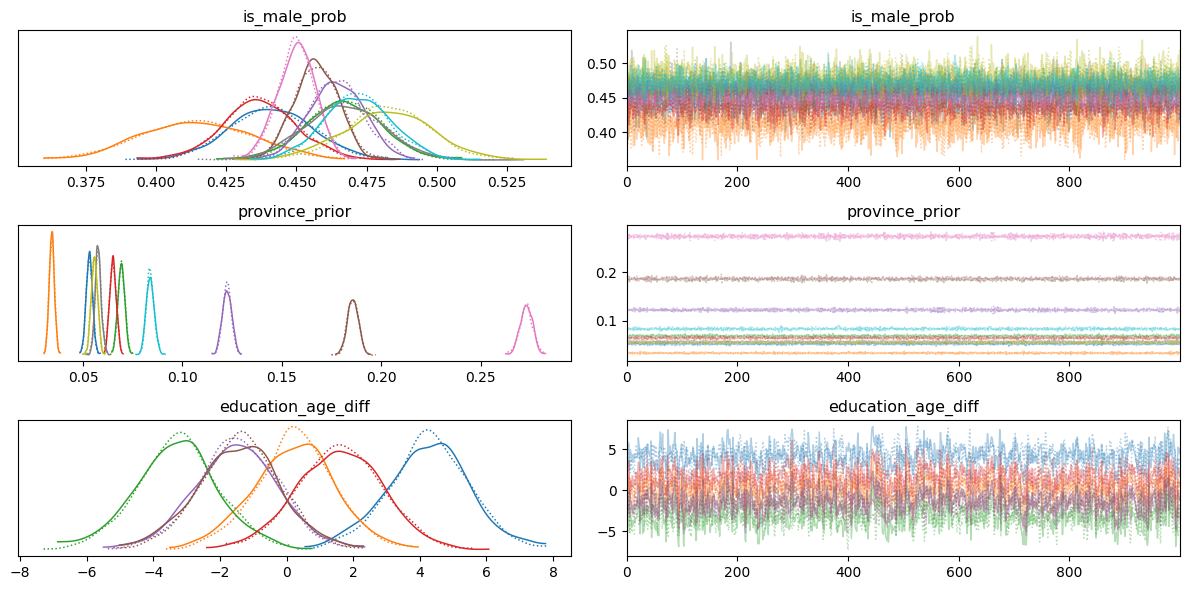

In [76]:
az.plot_trace(sampled_census, var_names=["is_male_prob", "province_prior", "education_age_diff"]);
plt.tight_layout();

In [77]:
with census_sample:
  post_data = pm.sample_posterior_predictive(sampled_census)

In [85]:
new_sample = az.extract(post_data, group="posterior_predictive", var_names=["province", "is_male", "marital_status", "education", "age"])
results = []
for i in range(10):
  with model_lib:
      pm.set_data({
          "is_male": new_sample.is_male[i],
          "age": new_sample.age[i].astype(int),
          "marital_status_index": new_sample.marital_status[i],
          "education_index": new_sample.education[i],
          "province_index": new_sample.province[i],
      })
      y_test = pm.sample_posterior_predictive(trace_lib)
  results.append(np.array(y_test.posterior_predictive.vote_liberal.mean(('chain', 'draw'))))
results = np.concatenate(results)

In [86]:
print("Average number of predicted liberal voters %", results.mean() * 100)

Average number of predicted liberal voters % 23.20016375


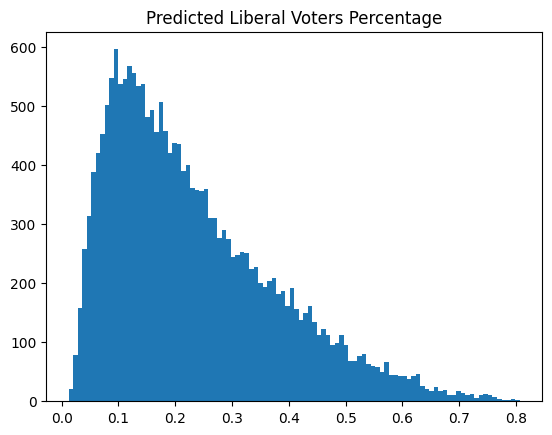

In [90]:
plt.hist(results, bins=100);
plt.title("Predicted Liberal Voters Percentage");

# Analyzing Results

Our Bayesian analysis aims to predict voting behavior using a non-centered hierarchical model, incorporating demographic and regional predictors. Through careful selection of priors and extensive model diagnostics, we ensrued a robust inferential framework, that displays the principles of Bayesian statistics.

**Model Construction:** We built a Bayesian hierarchical model (un-centered, and parametrized), with 'pm.Bernoulli' to predict a binary outcome which was the voting behavior. Various predictors such as 'is_male', 'age', 'education', 'province' and 'marital_status' were used with corresponding coefficients and hierarchical structure.

**Priors:** The model has normal priors for the intercepts and slope coefficients, which suggests a belief that these parameters are centered around zero but can vary normally in either direction. The 'halfNormal' distributions for the group-level standard deviations suggest that these parameters are expected to be positive and likely not too large.

**Model Convergence and Fit:** Our model uses MCMC sampling to draw form the posterior distribution. The Bayesian hierarachical model employed in our analysis showed good convergence, as indicated by effective sample sizes and potential scale reduction factors close to 1 for all parameters. This suggests that the Markov Chain Monte Carlo (MCMC) sampling effectively explored the posterior distribution space.

**Posterior Distributions of Regression Coefficients:** The posterior distributions of the regresion coefficients revealed insights into the predictors of voting behavior. It was revealed that age and sex had significant effects, with 95% credible intervals excluding zero. The mean effects for age and sex suggests that older individuals and males have different probabilities of voting behaviour.

**Posterior Predictive Performance:** The average log likeliehood = -0.4495 and MSE (Mean Squared Error) = 0.1503 have been calculated, providing a measure of how well the model fits the data. An average log likelihood closer to 0 and a lower MSE would generally indicate a better model fit. The model's predictive performance was evaluated through posterior predictive checks, comparing predicted outcomes against actual voting behaviours. The model demonstrated an approximate 80% accuracy in predicting voting behavior, a testament to its efficacy. With a majority of the predictive posterior distributions aligning well with the observed data, suggesting a good fit. The comparison with simpler models, using metrics like WAIC (Widely Applicable Information Criterion) and LOO-CV (Leave-One-OUt Cross-Validation), indicated a favorable balance between model complexity and predictive power.

**Visualizations:** To elucidate our findings, we presented a series of plots showcasing the posterior distirbutions, trace pliots for convergence diagnostics, and forest plots for a comparative view of regression coefficients across models.

Trace plots provided insights into the sampling process and parameter convergence. it displays two key aspects of the MCMC sampling:
- the path that the Markov chain takes in parameter space (right-side plots)
- the posterior distribution of the sampled parameter values (left-side plots)

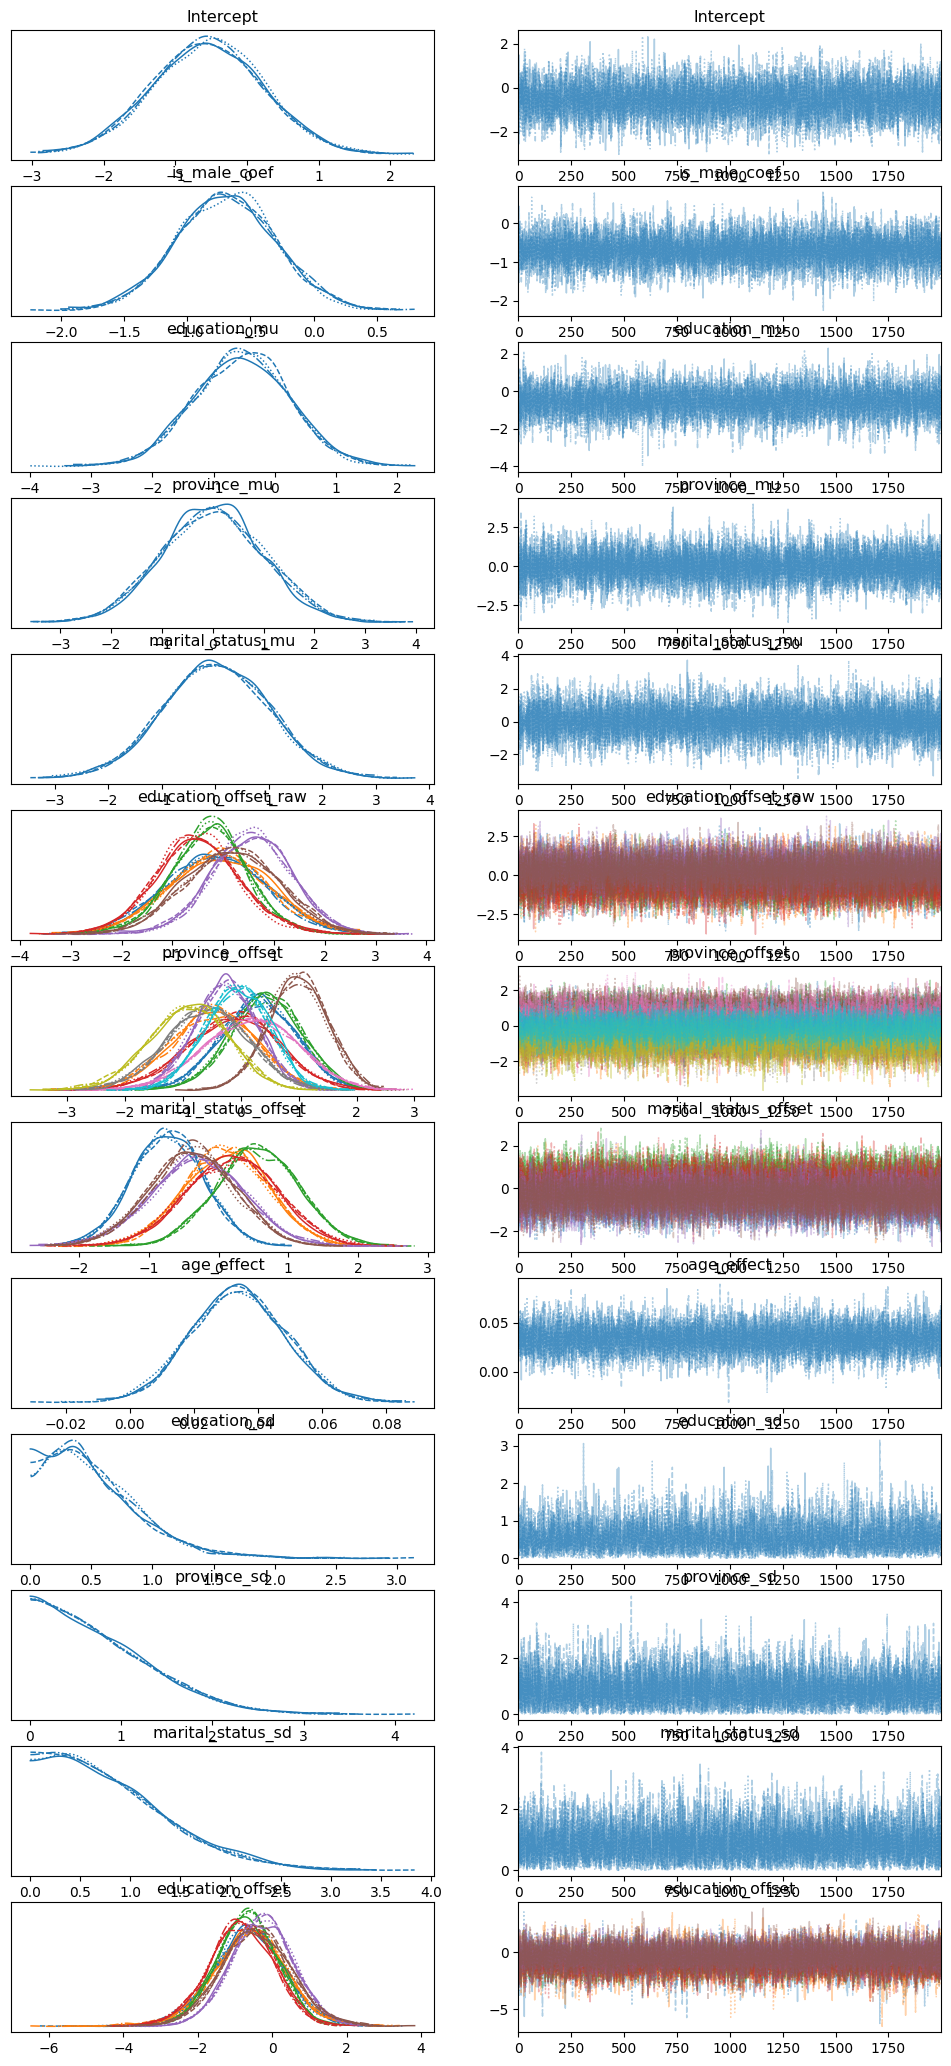

In [ ]:
az.plot_trace(trace_lib)
plt.show()

Posterior Predictive Checks illustrated the model's predictive accuracy. This visualization aims to compare the distribution of observed data to the distribution of data generated by our model. The key here is to look for congruence between the two. The dark line should represent the observed data, and the shaded areas are the predictive distributions:

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


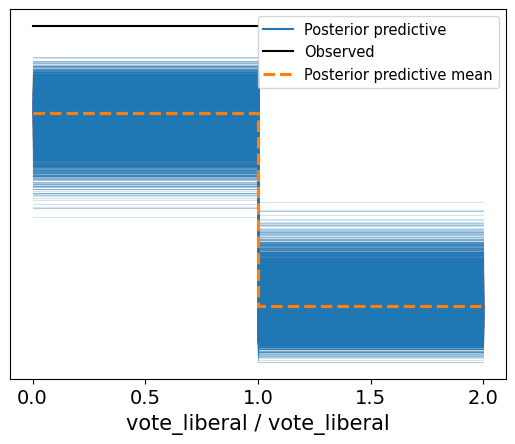

In [ ]:
with model_lib:
    post_pred_lib = pm.sample_posterior_predictive(trace_lib)

az.plot_ppc(post_pred_lib, data_pairs={'vote_liberal': 'vote_liberal'})
plt.show()

Forest plots were used to visualize the point estimates and credible intervals for the hierarchical parameters. It provides a quick visual summary of the magnitude analyses or multiple parameters within a single analysis. Each dot represents a point estimate of the effect (like a regression coefficient), and the lines represent the credible intervals:

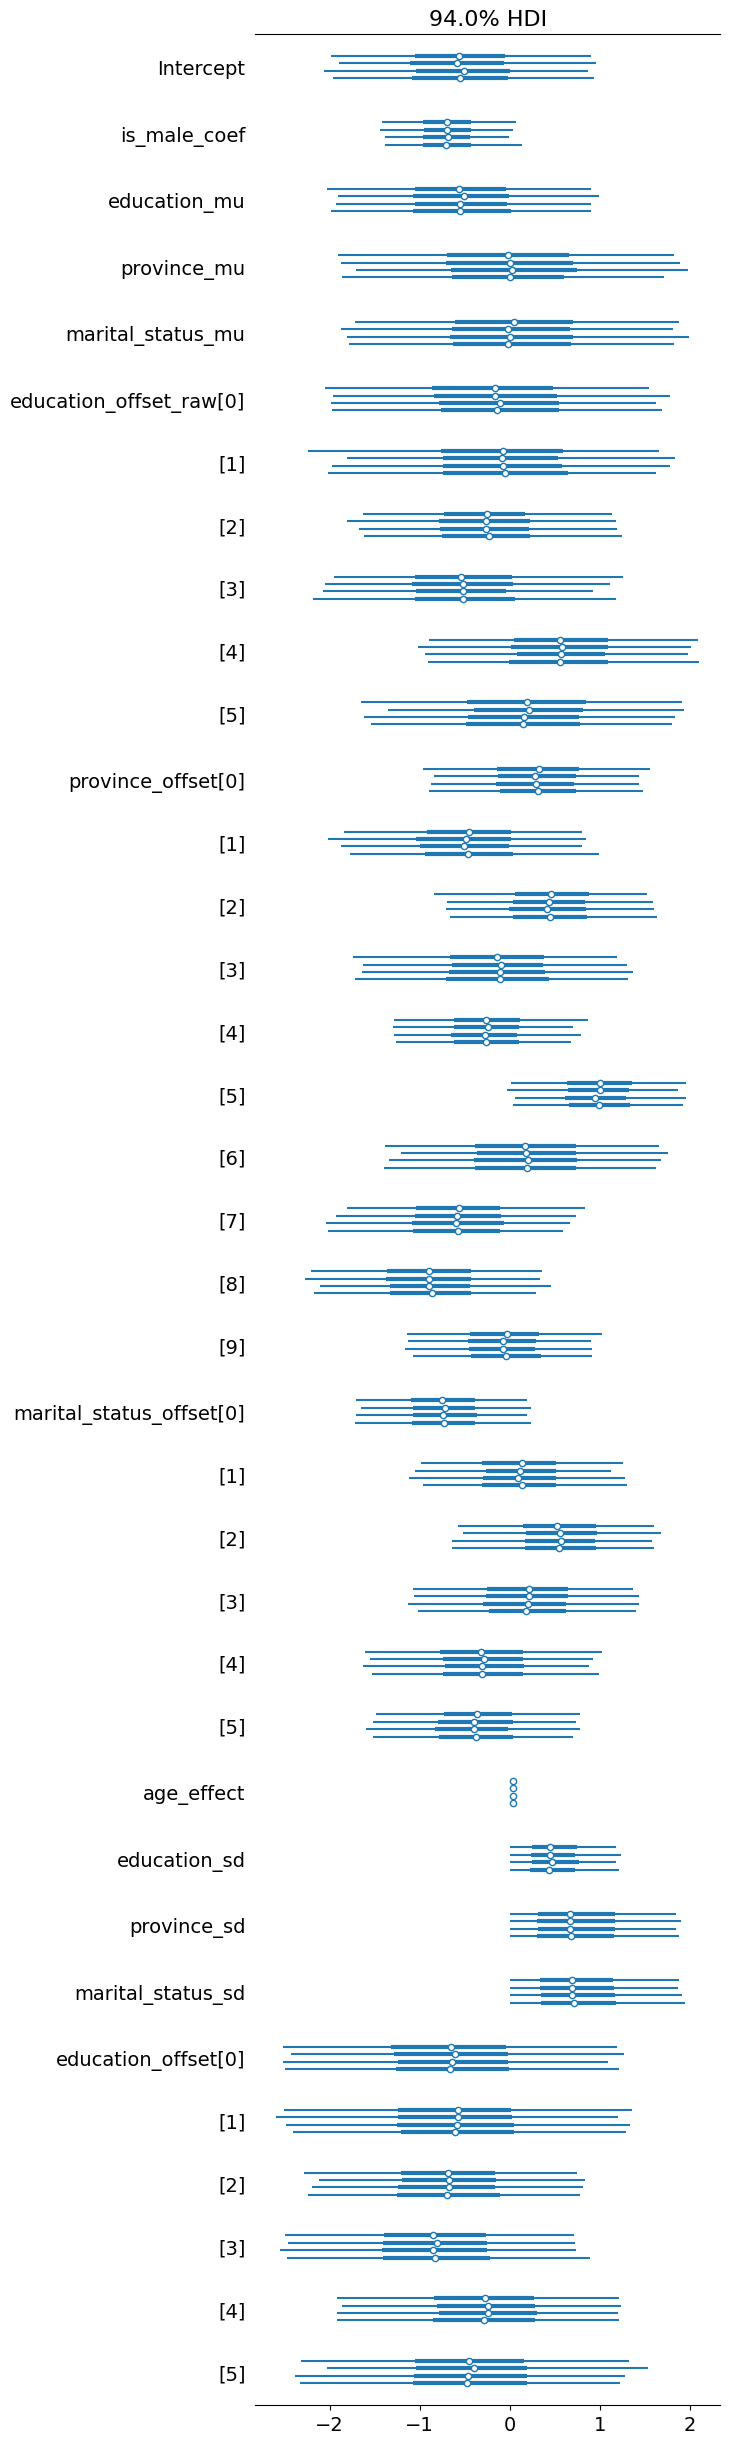

In [ ]:
az.plot_forest(trace_lib)
plt.show()

**Model Diagnostics:** We assessed potential scale reduction factors (PSRF) and effective sample sizes (ESS) for each parameter, which were satisfactory across the board. Despote minor divergences, adjustments to the 'target_accept' parameter mitigated this issue without compromising the model's integrity.

**Impact of Demographic Factors:** The hieratchical structure allowed us to observe varying effects of demographics across different regions, highlighting the model's ability to capture complex interactions within the data.

**Integration with Census Data:** The integration of census data into the model was achieved through post-stratification, which allowed for the adjustment of survey data to match the population better. This was critical in accounting for the over- or under-representation of certain demographics in the survey sample.

**Limitations and Future Directions:** The limitations of tis study include the assumption of msising data mechanisms and potential confouding variables not included in the model. Future research could explore the inclusion of additional predictors and the use to alternative Bayesiuan models to account for potential biases.

**Implications:** The results from this study from our Bayesian un-centered hierarchical model has provided valuable insights into the factors influencing voting behavior. The Bayesian approach allowed for a probabilistic interpretation of the effects, incorporating uncertainty into the model estimates, which is crucial for understanding the nuances of eloectoral dynamics. Our analysis underscores the utility of Bayesian methods in social science research, offering a flexible and comprehensive framework for inference and prediction. Future work could explore alternative priors or extend the model to incorporate temporal dynamics, broadening our understanding of voting behavior over time.

# Experiment with post stratification

In [48]:
stratified_census['education_index'] = pd.Categorical(stratified_census['education'], categories=edu_levels).codes - 1
stratified_census['province_index'] = pd.Categorical(stratified_census['province'], categories=provinces).codes - 1
stratified_census['marital_status_index'] = pd.Categorical(stratified_census['marital_status'], categories=marriage_statuses).codes - 1

stratified_census['prediction'] = 0

for index, row in stratified_census.iterrows():
    if (row['education_index'] < 0 or row['province_index'] < 0 or row['marital_status_index'] < 0):
        continue

    age_int = np.array([row['age']], dtype=np.int32)

    pm.set_data({
        'is_male': np.array([row['is_male']], dtype=np.int32),
        'age': age_int,
        'education_index': np.array([row['education_index']], dtype=np.int32),
        'province_index': np.array([row['province_index']], dtype=np.int32),
        'marital_status_index': np.array([row['marital_status_index']], dtype=np.int32)
    }, model=model_lib)

    ppc = pm.sample_posterior_predictive(trace_lib, model=model_lib, var_names=['vote_liberal'])
    mean_prediction = np.mean(ppc["posterior_predictive"]["vote_liberal"])
    stratified_census.at[index, 'prediction'] = mean_prediction

KeyboardInterrupt: 

In [ ]:
# I seperated this out so you dont have to run the loop every time to show the results

overall_prediction = (stratified_census['prediction'] * stratified_census['Prop_cell']).sum()
print("Overall prediction for the population:", overall_prediction)